# Рабочая тетрадь - распознавание рукописных цифр

In [40]:
!pip install scikit-learn
!pip install mnist
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import os

In [41]:
train, validation = tf.keras.datasets.mnist.load_data()

In [42]:
x = train[0].reshape(-1, 28, 28)
y = train[1]

x_validation = validation[0].reshape(-1, 28, 28)
y_validation = validation[1]

In [43]:
y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [44]:
x.shape

(60000, 28, 28)

In [45]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '5')

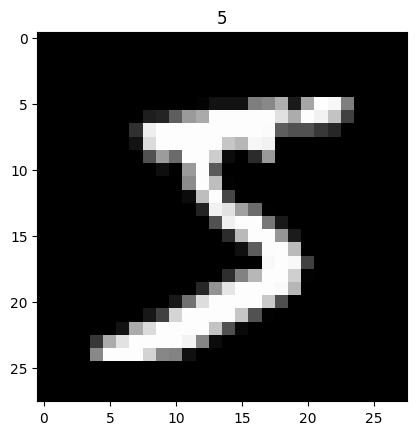

In [46]:
plt.imshow(x[0], cmap="gray")
plt.title(y[0])

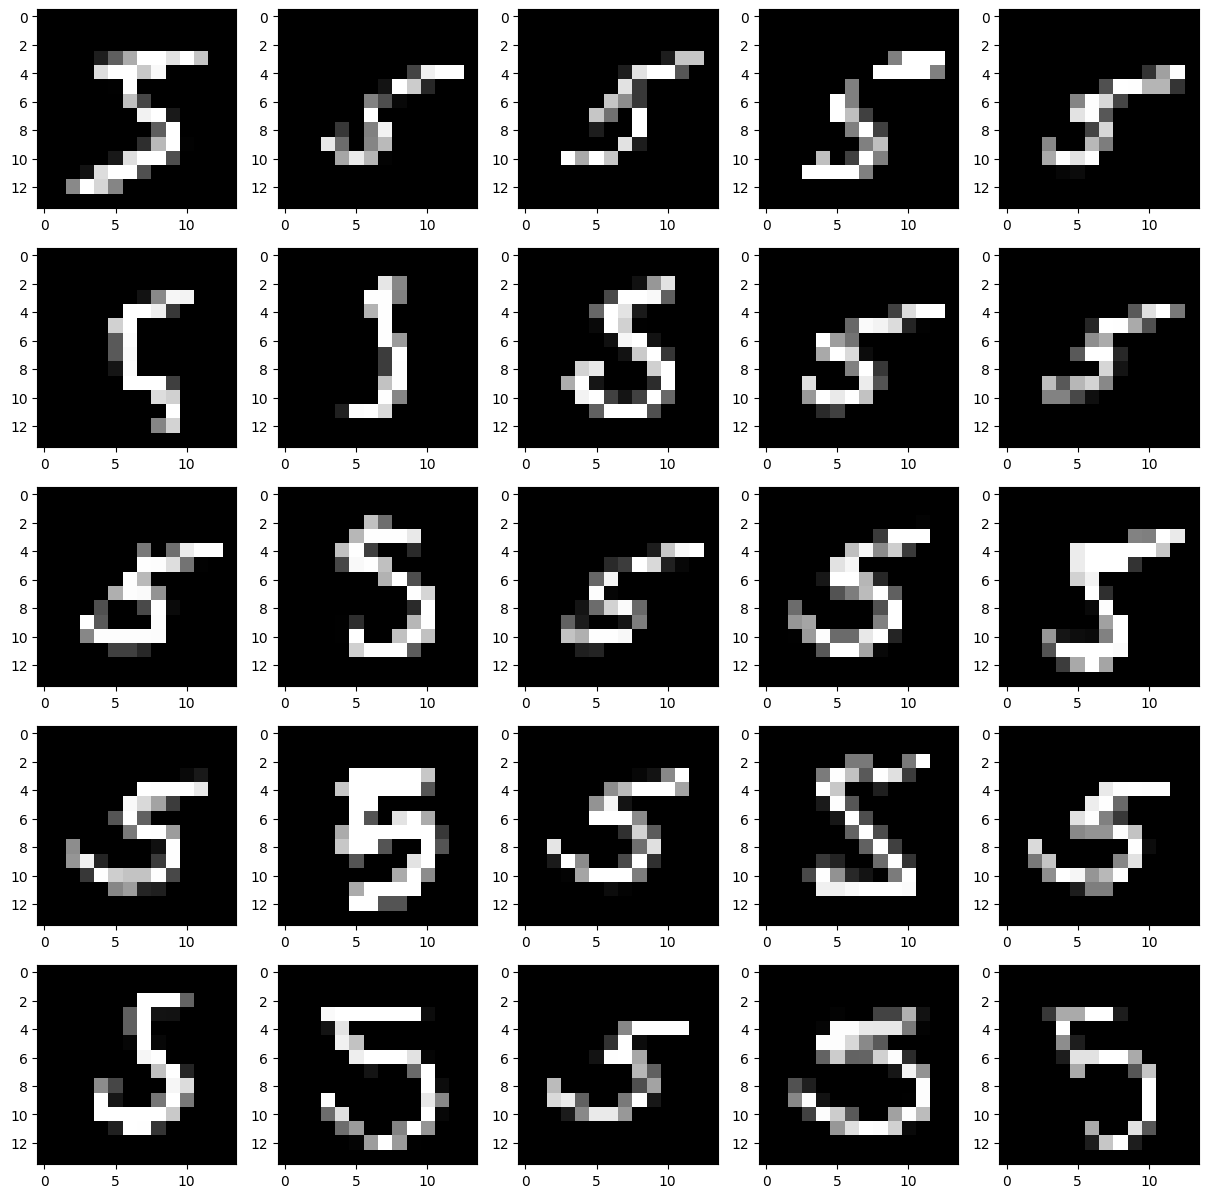

In [47]:
fig, axs = plt.subplots(5,5, figsize=(15,15))
x_subset = x[y==5]
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(x_subset[5*i + j][::2, ::2], cmap="gray")

In [48]:
from sklearn.neighbors import KNeighborsClassifier as kNN

In [49]:
clf = kNN()

In [50]:
clf.fit(x.reshape(-1, 784), y)

KNeighborsClassifier()

In [51]:
%%time
y_pred = clf.predict(x_validation.reshape(-1, 784))

CPU times: user 54 s, sys: 3.26 s, total: 57.3 s
Wall time: 1min 10s


In [52]:
x_validation.shape

(10000, 28, 28)

In [53]:
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [54]:
y_validation

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [55]:
import numpy as np
np.sum(y_pred != y_validation).item() / len(y_validation)

0.0312

## Ресайзим картинки

In [56]:
clf2 = kNN()
clf2.fit(x[: ,::2,::2].reshape(-1, 14*14), y)

KNeighborsClassifier()

In [57]:
%%time
y_pred2 = clf2.predict(x_validation[: ,::2,::2].reshape(-1, 14*14))

CPU times: user 18.7 s, sys: 3.06 s, total: 21.8 s
Wall time: 15.1 s


In [58]:
np.sum(y_pred2 != y_validation).item() / len(y_validation)

0.0379

## Уменьшение размерности с помощью PCA

In [59]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)

In [60]:
pca.fit(x.reshape(-1, 784))

PCA(n_components=16)

In [61]:
x_transformed = pca.transform(x.reshape(-1, 784))
x_validation_transformed = pca.transform(x_validation.reshape(-1, 784))

In [62]:
x_transformed.shape, x_validation_transformed.shape

((60000, 16), (10000, 16))

In [63]:
clf3 = kNN()
clf3.fit(x_transformed, y)

KNeighborsClassifier()

In [64]:
%%time
y_pred3 = clf3.predict(x_validation_transformed)

CPU times: user 3.59 s, sys: 4.2 ms, total: 3.59 s
Wall time: 3.54 s


In [65]:
np.sum(y_pred3 != y_validation).item() / len(y_validation)

0.037

## Случайный алгоритм

In [66]:
y_pred4 = np.random.randint(low=0, high=10, size=len(y_validation))

In [67]:
y_pred4

array([9, 7, 2, ..., 6, 1, 3])

In [68]:
print("доля правильных ответов (accuracy):", np.sum(y_pred4 == y_validation).item() / len(y_validation))

доля правильных ответов (accuracy): 0.0975


# Визуализация с помощью t-SNE

In [69]:
from sklearn.manifold import TSNE

In [70]:
tsne = TSNE(n_components=2)

In [71]:
x_tsne = tsne.fit_transform(x[:2000].reshape(-1, 784))

In [72]:
x_tsne.shape

(2000, 2)

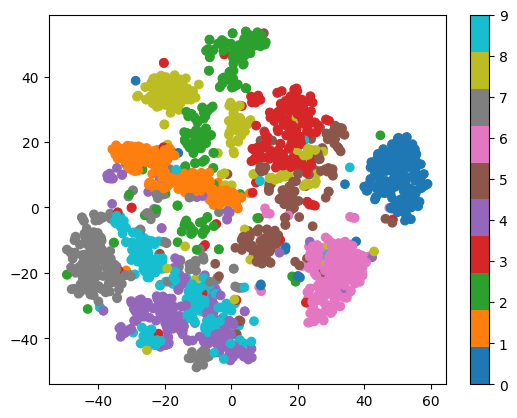

In [73]:
import matplotlib.pyplot as plt
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y[:2000], cmap="tab10")
plt.colorbar()

In [74]:
import numpy as np
import matplotlib.pyplot as plt

class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = self.components = self.explained_variance = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
        self.components = Vt
        self.explained_variance = s ** 2 / (X.shape[0] - 1)

        if self.n_components:
            max_comp = min(X.shape[0], X.shape[1])
            self.n_components = min(self.n_components, max_comp)
            self.components = self.components[:self.n_components]
            self.explained_variance = self.explained_variance[:self.n_components]

        return self

    def transform(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("Сначала вызовите fit()")
        return np.dot(X - self.mean, self.components.T)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [75]:
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.x_train = self.y_train = None

    def fit(self, X, y):
        self.x_train, self.y_train = X, y
        return self

    def predict(self, X):
        distances = np.sqrt(((X[:, np.newaxis] - self.x_train) ** 2).sum(axis=2))
        nearest = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        predictions = []
        for labels in self.y_train[nearest]:
            unique, counts = np.unique(labels, return_counts=True)
            predictions.append(unique[np.argmax(counts)])

        return np.array(predictions)

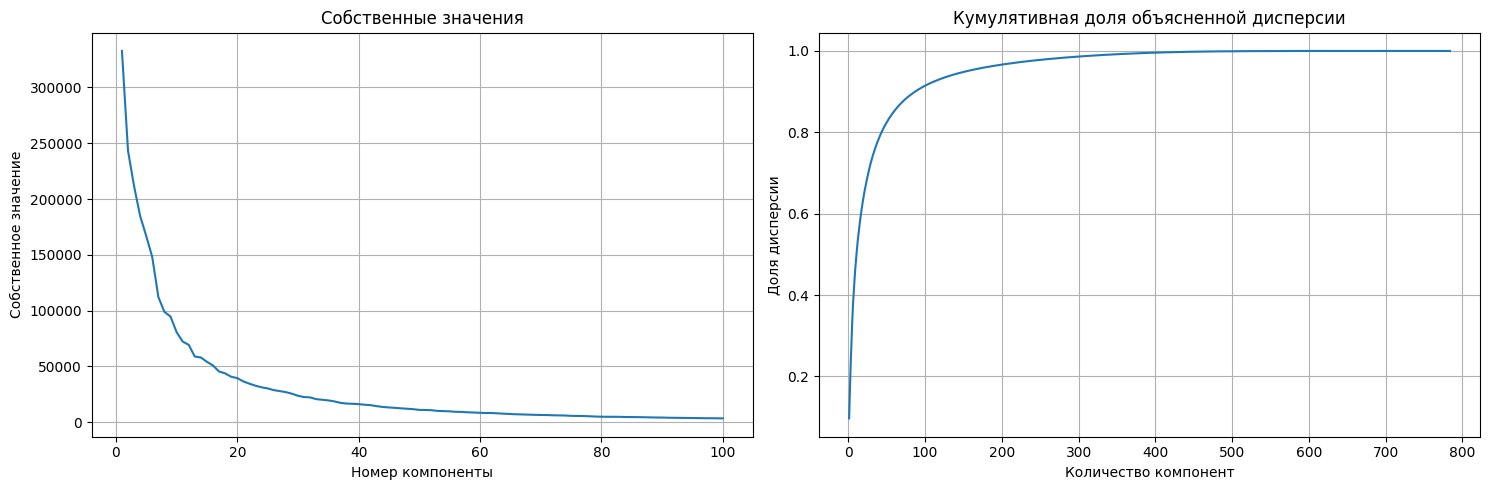

Доля дисперсии первых 15 компонент: 0.5793 (57.93%)


In [76]:
x_2d = x.reshape(-1, 28*28)
pca = my_PCA().fit(x_2d)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
n_plot = min(100, len(pca.explained_variance))
plt.plot(range(1, n_plot + 1), pca.explained_variance[:n_plot])
plt.xlabel('Номер компоненты'), plt.ylabel('Собственное значение')
plt.title('Собственные значения'), plt.grid(True)
plt.subplot(1, 2, 2)
cum_var = np.cumsum(pca.explained_variance) / np.sum(pca.explained_variance)
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel('Количество компонент'), plt.ylabel('Доля дисперсии')
plt.title('Кумулятивная доля объясненной дисперсии'), plt.grid(True)
plt.tight_layout()
plt.show()
print(f"Доля дисперсии первых 15 компонент: {cum_var[14]:.4f} ({cum_var[14]*100:.2f}%)")

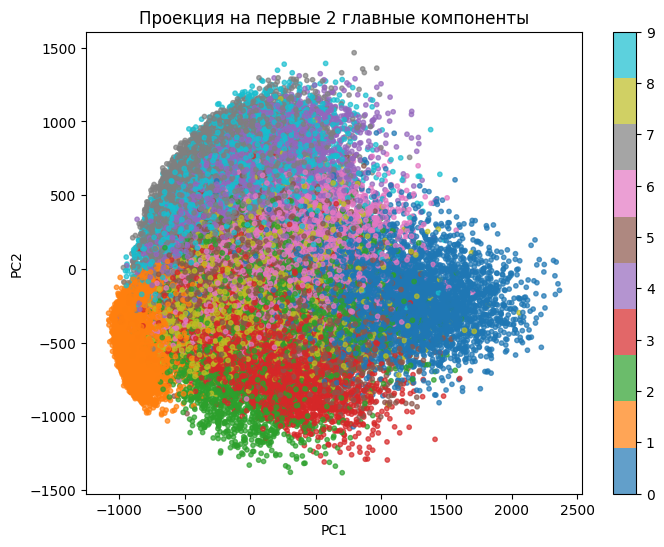

In [84]:
pca2 = my_PCA(n_components=2).fit_transform(x_2d)
np.random.seed(0)
idx = np.random.choice(len(pca2), 2000, replace=False)
plt.figure(figsize=(8,6))
plt.scatter(pca2[:,0], pca2[:,1], c=y, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("PC1"), plt.ylabel("PC2")
plt.title("Проекция на первые 2 главные компоненты")
plt.colorbar()
plt.show()